Здесь находятся разборы заданий "со звёздочкой". 

In [1]:
import pandas as pd
import pandahouse as ph
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
### подключаюсь к БД

connection = {
                'host': 'https://clickhouse.lab.karpov.courses',
                'password': 'dpo_python_2020',
                'user': 'student',
                'database': 'simulator_20230120'
              }


### вывожу  датафрейм
### в бд сейчас миллионы строк, пандас такое не потянет, поэтому делаю запрос в 5 строк сверить столбцы

query = '''
            SELECT *
            FROM {db}.feed_actions
            LIMIT 5
        '''

df = ph.read_clickhouse(query, connection=connection)
df.head()

,user_id,post_id,action,time,gender,age,country,city,os,source,exp_group
0,126581,6127,view,2023-02-28 09:25:27,1,15,Russia,Yoshkar-Ola,iOS,organic,2
1,141796,5983,view,2023-02-28 09:25:27,0,20,Russia,Moscow,Android,organic,0
2,147578,6145,view,2023-02-28 09:25:27,1,17,Russia,Moscow,iOS,organic,0
3,156973,6208,like,2023-02-28 09:25:27,0,21,Russia,Aleksin,Android,organic,2
4,164863,6194,view,2023-02-28 09:25:27,0,47,Russia,Yemanzhelinka,Android,organic,3


### task_9-1

Проводить исследования и интерпретировать их результаты - одна из главных задач аналитика, но для правильной постановки гипотезы нужно понимать, что происходит в данных.

Этим мы и займёмся - давайте познакомимся с нашими данными чуть ближе, чем названия колонок и их содержание! Первое, что мы можем сделать - это посчитать описательные статистики по лайкам и просмотрам в группировке по постам.

Укажите, что из этого НЕ ХАРАКТЕРНО для наших данных:

* По мерам центральной тенденции просмотры опережают лайки
* Медиана лайков приблизительно такая же, как и среднее по ним же
* Самые популярные посты собирают миллионы просмотров

### solution_9-1

In [3]:
query_9_1 = '''
                SELECT post_id, action, COUNT(user_id) AS user_id
                FROM simulator_20230120.feed_actions
                GROUP BY post_id, action
            '''

df_9_1 = ph.read_clickhouse(query_9_1, connection=connection)
df_9_1.head()

,post_id,action,user_id
0,3087,like,449
1,4443,like,869
2,814,like,2712
3,3865,like,15
4,4685,like,3757


In [4]:
df_9_1 = df_9_1.pivot(index = "post_id", columns="action", values="user_id")
df_9_1

action,like,view
post_id,,
1,160.0,1086.0
2,3.0,44.0
3,257.0,1496.0
4,849.0,4128.0
5,6.0,90.0
...,...,...
6462,125.0,863.0
6473,162.0,645.0
6476,199.0,761.0


In [5]:
### cтоит обратить внимание на тот факт, что у нас есть данные без лайков, но с просмотрами - на месте лайков в датафрейме будут NaN. Поэтому стоит заполнить их нулями при помощи .fillna(0). Можно также поискать посты, которые даже не посмотрели (вычислив их по id), но особой пользы для нас они в данном случае не имеют. 

df_9_1.fillna(0).describe().round(2)

action,like,view
count,6160.00,6160.00
mean,1534.45,7327.30
std,2946.53,11331.27
min,0.00,1.00
25%,48.00,533.00
50%,322.50,2627.00
75%,1532.75,9075.75
max,31714.00,104338.00


**Вывод**

* По мерам центральной тенденции просмотры опережают лайки **(Верно)**
* Медиана лайков приблизительно такая же, как и среднее по ним же (Не верно)
* Самые популярные посты собирают миллионы просмотров (Не верно)

### task_9-2

Нарисуйте распределения просмотров и лайков по постам. Какая у них форма и есть ли различия в этой форме? Выберите правильные варианты:

* Есть пик около нуля/единицы как для просмотров, так и для лайков
* В данных хорошо видны подгруппы
* Стандартизированные лайки отличаются от стандартизированных просмотров по своим правым "хвостам" - концам распределений
* Для данных характерна положительная асимметрия
* Для данных характерна левосторонняя асимметрия

### solution_9-2

In [6]:
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples

<AxesSubplot:xlabel='view', ylabel='Count'>

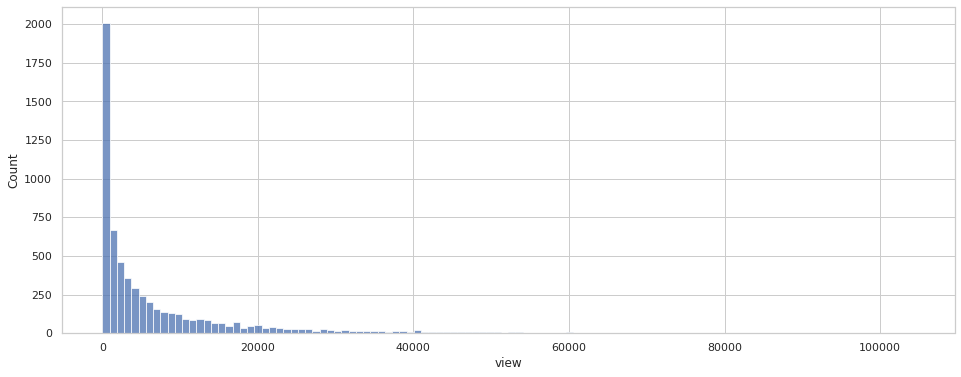

In [7]:
sns.set(rc={'figure.figsize':(16,6)}, style="whitegrid") 

sns.histplot(x="view", data=df_9_1)

<AxesSubplot:xlabel='like', ylabel='Count'>

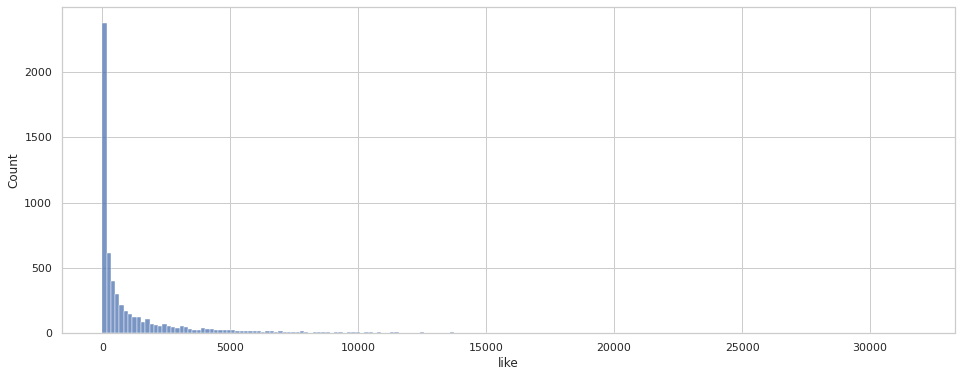

In [8]:
sns.histplot(x="like", data=df_9_1)

Что мы здесь явно можем сказать? Пик примерно около нуля действительно заметен. Асимметрия здесь правосторонняя - или, как её ещё называют, положительная. Подгрупп не видно.

In [9]:
z_data = df_9_1.copy()

z_data["like"] = (z_data["like"] - z_data["like"].mean())/z_data["like"].std()
z_data["view"] = (z_data["view"] - z_data["view"].mean())/z_data["view"].std()

z_data.head()

action,like,view
post_id,,
1,-0.473476,-0.550803
2,-0.526377,-0.642761
3,-0.440793,-0.514620
4,-0.241319,-0.282343
5,-0.525367,-0.638702


/nfs/env/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


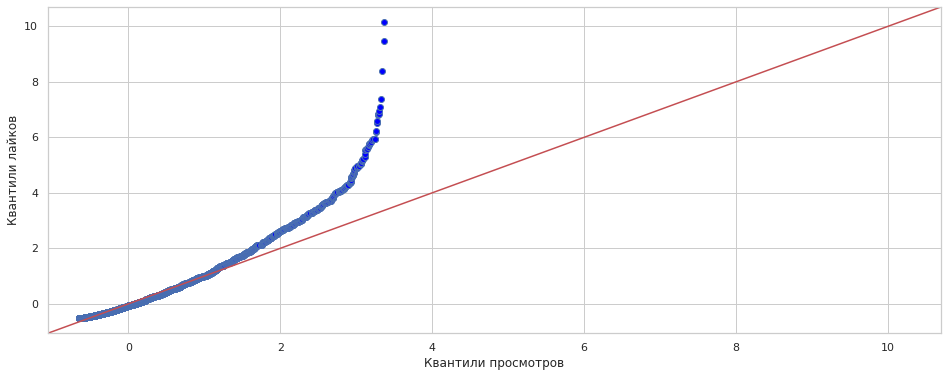

In [10]:
qqplot_2samples(z_data["like"], z_data["view"], line="45", xlabel="Квантили просмотров", ylabel="Квантили лайков")
plt.show()

Если бы наши распределения идеально совпадали по своей форме, то всё легло бы на прямую линию. Однако мы можем заметить по этой картинке, что ближе середине графика точки резко уходят от линии всё дальше и дальше вверх. Таким образом, мы можем сделать вывод, что в своих правых "хвостах" распределения отличаются друг от друга.

**Вывод:**

* Есть пик около нуля/единицы как для просмотров, так и для лайков **(Верно)**
* В данных хорошо видны подгруппы (Не верно)
* Стандартизированные лайки отличаются от стандартизированных просмотров по своим правым "хвостам" - концам распределений **(Верно)**
* Для данных характерна положительная асимметрия **(Верно)**
* Для данных характерна левосторонняя асимметрия (Не верно)

### task_9-3

Посчитайте CTR и время существования для каждого из постов (от первого просмотра поста). Затем:

1. Нарисуйте их распределения
2. Постройте корреляционную матрицу между ними, просмотрами и лайками
3. Визуализируйте все эти взаимосвязи в виде диаграмм рассеяния

Каикие утверждения верны: 
* Сильнее всего коррелируют CTR и время существования поста
* Между количеством лайков и временем существования поста связь линейная
* По сравнению с просмотрами и лайками CTR менее асимметричен
* В среднем посты "живут" пять дней

### solution_9-3

<AxesSubplot:xlabel='ctr', ylabel='Count'>

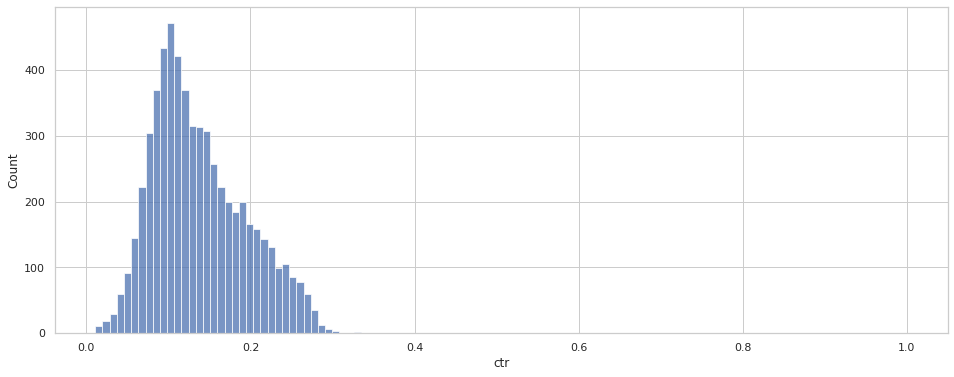

In [11]:
df_9_1['ctr'] = df_9_1['like'] / df_9_1['view']

sns.histplot(x="ctr", data=df_9_1)

Видно, что асимметрия не такая резкая - но всё же присутствует!

In [12]:
### cреднее время жизни поста

query_9_3 = '''
                SELECT AVG(life_time) AS avg_life_time_days
                FROM
                (SELECT 
                    post_id, 
                    COUNT(action) FILTER(WHERE action='like') AS likes, 
                    COUNT(action) FILTER(WHERE action='view') AS views,
                    likes/views AS CTR,
                    MIN(time) AS min_time,
                    MAX(time) AS max_time,
                    DATEDIFF('day', min_time, max_time) AS life_time,
                    AVG(life_time) OVER()
                FROM simulator_20230120.feed_actions
                GROUP BY post_id)
                '''
avg_life_time = ph.read_clickhouse(query_9_3, connection=connection)
avg_life_time

,avg_life_time_days
0,1.875649


В среднем посты живут около 1.88084 дней или 45 часов - что явно не 5 дней.

In [13]:
### корреляционная матрица

query_9_3 = '''
                SELECT 
                    COUNT(action) FILTER(WHERE action='like') AS likes, 
                    COUNT(action) FILTER(WHERE action='view') AS views,
                    likes/views AS CTR,
                    MIN(time) AS min_time,
                    MAX(time) AS max_time,
                    DATEDIFF('day', min_time, max_time) AS life_time
                FROM simulator_20230120.feed_actions
                GROUP BY post_id
                '''
df_9_3 = ph.read_clickhouse(query_9_3, connection=connection)
df_9_3


df_9_3.corr()

,likes,views,CTR,life_time
likes,1.000000,0.989949,0.746907,0.798165
views,0.989949,1.000000,0.794346,0.843684
CTR,0.746907,0.794346,1.000000,0.870557
life_time,0.798165,0.843684,0.870557,1.000000


Видно, что лайки и просмотры коррелируют сильнее всего (0.989950)

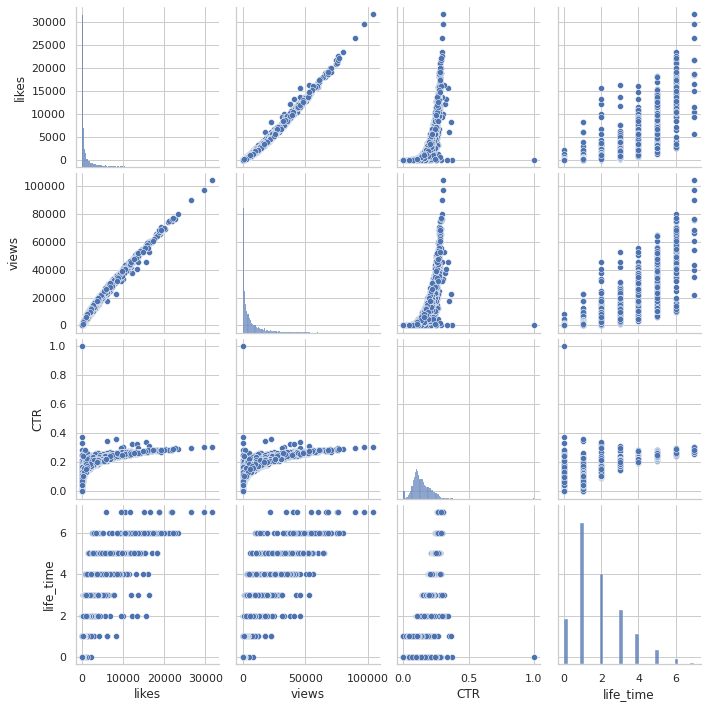

In [14]:
sns.pairplot(df_9_3)

Тоже самое подтверждает визуализация.

**Вывод:**
 
* Сильнее всего коррелируют CTR и время существования поста (Не верно)
* Между количеством лайков и временем существования поста связь линейная (Не верно)
* По сравнению с просмотрами и лайками CTR менее асимметричен **(Верно)**
* В среднем посты "живут" пять дней (Не верно)

### task_9-4

Нарисуйте дневную динамику активности уникальных пользователей, а затем просмотра уникальных постов.

### solution_9-4

In [15]:
### DAU

query_9_4_DAU = '''
                    SELECT
                        toDate(time) as day, 
                        uniqExact(user_id) as DAU
                    FROM simulator_20230120.feed_actions
                    GROUP BY day
                '''
DAU = ph.read_clickhouse(query_9_4_DAU, connection=connection)
DAU


,day,DAU
0,2022-12-05,1198
1,2022-12-06,2325
2,2022-12-07,3388
3,2022-12-08,4121
4,2022-12-09,4917
...,...,...
84,2023-02-27,18984
85,2023-02-28,18902
86,2023-03-01,19388
87,2023-03-02,19025


<AxesSubplot:xlabel='day', ylabel='DAU'>

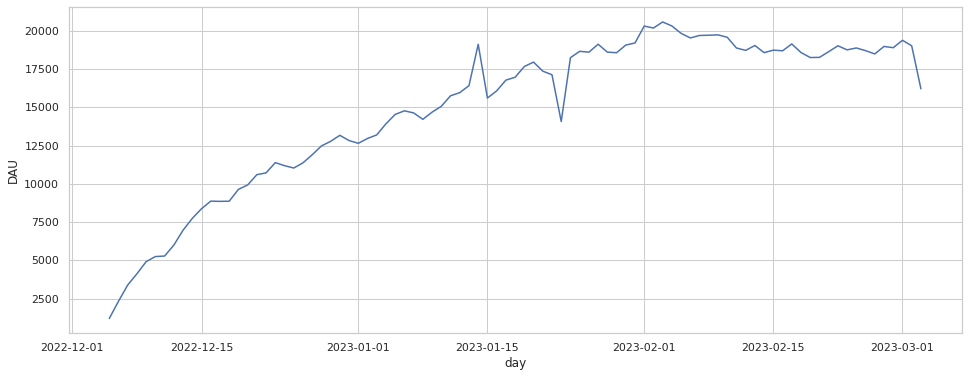

In [16]:
sns.lineplot(data=DAU, x='day', y='DAU')

DAU у нас выглядит так - тот самый "постоянный рост с небольшими флуктуациями", хотя видны и изменения более крупного масштаба:

In [17]:
### уникальные посты

query_9_4_posts = '''
                    SELECT toStartOfDay(toDateTime(time)) AS day,
                           count(DISTINCT post_id) AS posts
                    FROM simulator_20230120.feed_actions
                    WHERE action = 'view'
                    GROUP BY day
                    ORDER BY posts DESC
                '''
uniqe_posts = ph.read_clickhouse(query_9_4_posts, connection=connection)
uniqe_posts


,day,posts
0,2023-01-08,247
1,2023-02-27,240
2,2023-01-07,240
3,2023-01-09,239
4,2023-02-26,238
...,...,...
84,2023-02-03,165
85,2023-01-18,163
86,2022-12-06,150
87,2023-03-03,140


<AxesSubplot:xlabel='day', ylabel='posts'>

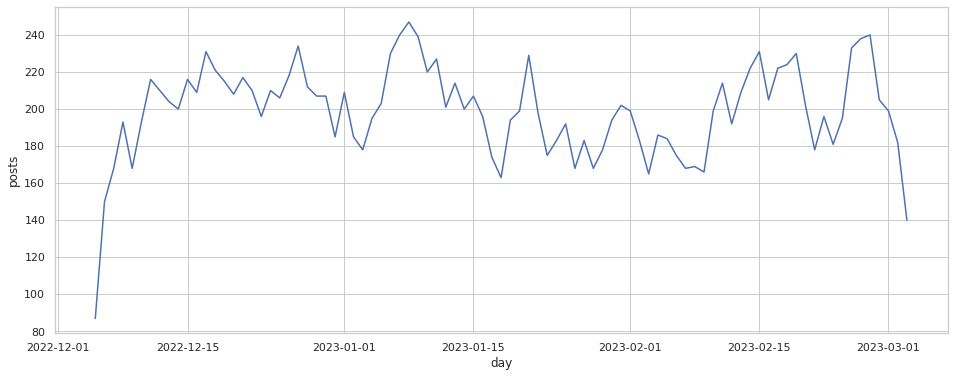

In [18]:
sns.lineplot(data=uniqe_posts, x='day', y='posts')

В свою очередь если смотреть на посты, то их количество реально быстро растёт в самом начале существования нашего стартапа, а затем превращается в стационарный временной ряд

**Вывод:**

* Уникальные пользователи - Постоянный рост с небольшими флуктуациями

* Просмотры уникальных постов - Резкий рост в начале, затем случайные колебания вокруг одного уровня

### task_9-5

Мы посмотрели как на вклад пользователей, так и вклад постов в общую динамику просмотров и лайков. Однако не менее полезной может оказаться декомпозиция временного ряда на компоненты - чтобы выделить отдельные составляющие части процесса.

Возьмите почасовую динамику активности за весь период и проанализируйте её этой функцией statsmodels.tsa.seasonal.STL. Соотнесите получившийся результат с его интерпретацией:

*
*
*


### solution_9-5

In [19]:
from statsmodels.tsa.seasonal import STL

In [20]:
### почасовая динамика активности за весь период

qury_9_5 = '''
            SELECT
                toStartOfHour(time) as day_h, 
                COUNT(user_id) as actions
            FROM simulator_20230120.feed_actions
            GROUP BY day_h
            ORDER BY day_h
            '''

actions_by_hour = ph.read_clickhouse(qury_9_5, connection=connection)
actions_by_hour

,day_h,actions
0,2022-12-05 00:00:00,61
1,2022-12-05 01:00:00,65
2,2022-12-05 02:00:00,45
3,2022-12-05 03:00:00,30
4,2022-12-05 04:00:00,38
...,...,...
2125,2023-03-03 13:00:00,31401
2126,2023-03-03 14:00:00,31414
2127,2023-03-03 15:00:00,33491
2128,2023-03-03 16:00:00,35019


In [21]:
actions_by_hour.set_index('day_h', inplace=True)
actions_by_hour

,actions
day_h,
2022-12-05 00:00:00,61
2022-12-05 01:00:00,65
2022-12-05 02:00:00,45
2022-12-05 03:00:00,30
2022-12-05 04:00:00,38
...,...
2023-03-03 13:00:00,31401
2023-03-03 14:00:00,31414
2023-03-03 15:00:00,33491


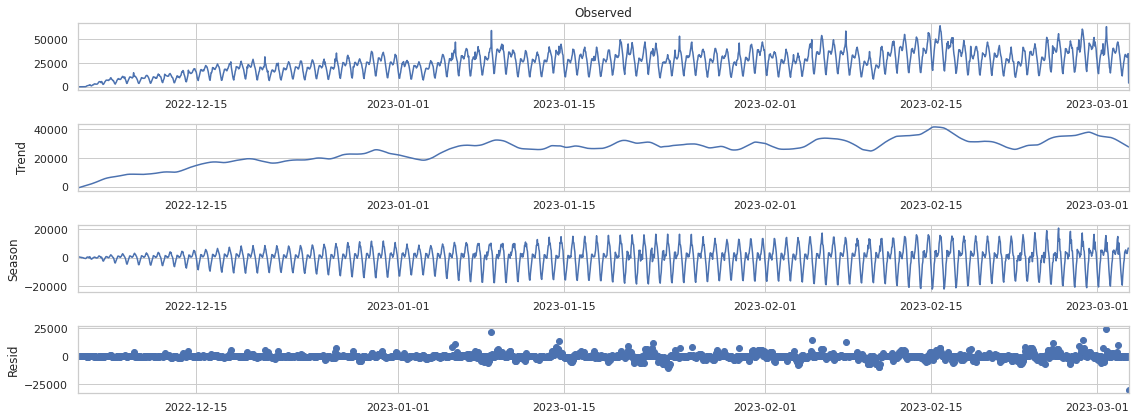

In [22]:
### можно поиграться с параметрами сезонности, тренда и другими аргументами функции

res = STL(actions_by_hour, robust=True).fit() # сделаем менее подверженную выбросам декомпозицию
res.plot()
plt.show()

**Вывод:**

* Самым первым идёт временной ряд, который мы и пытаемся декомпозировать.

* Затем идёт тренд - как меняется средняя тенденция временного ряда. Можно настроить аргумент trend - туда можно подавать целые нечётные числа, таким образом настраивая "извилистость" тренда. Здесь можно задать более высокие значения аргумента, чтобы линия была более гладкой.

* Дальше идёт дневная сезонность - почасовые колебания активности в течение дня. Можно обратить внимание на то, что у нас явная мультипликативная сезонность.

* Наконец, последними идут остатки модели - всё то, что осталось после выделения тренда и сезонности. В них не должно быть каких-то явных паттернов - их наличие может означать неадекватность нашей декомпозиции. 

### task_9-6

Вы могли заметить из прошлого задания, что просмотры постов "колеблются" в течение дня. Вопрос: а отличается ли распределение дневной активности пользователей от распределения публикации постов? В качестве прокси времени публикации возьмите время первого просмотра поста.

Визуализируйте оба распределения для каждого часа дня и выберите правильные варианты ответа:

* Посты публикуются круглосуточно
* Примерно с 9 утра до 4 вечера активность пользователей одинаковая, с небольшой "просадкой" посередине
* Пики активности пользователей и публикации постов не совпадают
* Для активности пользователей характерен линейный рост в течение дня, сопровождающийся падением
* Больше всего постов публикуется в районе 8 вечера
* Наименьшая активность пользователей наблюдается в 5 утра

### solution_9-6

In [23]:
### распределение дневной активности пользователей

query_9_6_actions = '''
                        SELECT
                            toHour(time) as hour,
                            COUNT(user_id) as actions
                        FROM simulator_20230120.feed_actions
                        GROUP BY hour
                        ORDER BY hour
                    '''
actions_by_hour = ph.read_clickhouse(query_9_6_actions, connection=connection)

In [24]:
actions_by_hour

,hour,actions
0,0,2156801
1,1,1796882
2,2,1340245
3,3,983702
4,4,931700
5,5,1315621
6,6,1621863
7,7,1983776
8,8,2201065
9,9,2545512


<AxesSubplot:xlabel='hour', ylabel='actions'>

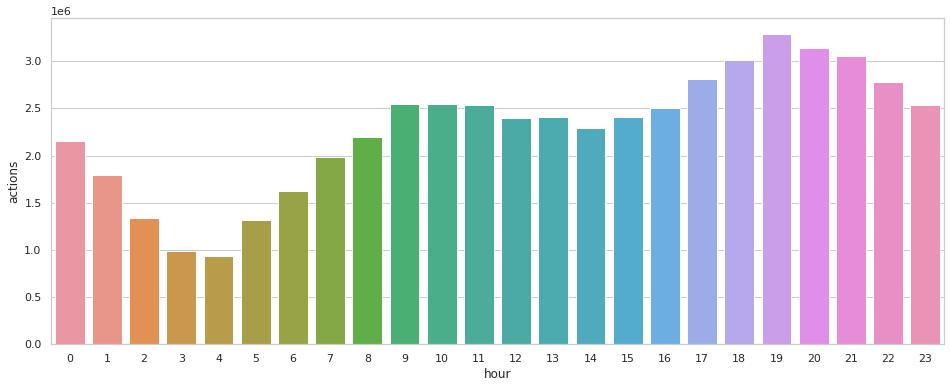

In [25]:
sns.barplot(data = actions_by_hour, x='hour', y='actions')

Что можно видеть: 

* С 9 до 16 действительно пользовательская активность довольно стабильная (хоть и немного снижается к 14 часам)
* Рост активности пользователей явно нелинеен
* Наименьшая активность наблюдается в 4 утра

In [26]:
### распределение дневной активности пользователей

query_9_6_posts = '''
                    SELECT
                        hour,
                        COUNT(DISTINCT post_id) as posts
                    FROM
                        (SELECT
                            post_id,
                            publication_time,
                            toHour(publication_time) as hour
                        FROM
                            (SELECT
                                post_id,
                                MIN(toStartOfHour(time)) as publication_time
                            FROM simulator_20230120.feed_actions
                            GROUP BY post_id
                            ORDER BY publication_time))
                    GROUP BY hour 
                '''
new_posts_by_hour = ph.read_clickhouse(query_9_6_posts, connection=connection)

In [27]:
new_posts_by_hour

,hour,posts
0,0,190
1,1,67
2,2,11
3,9,1
4,10,5
5,11,12
6,12,22
7,13,72
8,14,174
9,15,249


<AxesSubplot:xlabel='hour', ylabel='posts'>

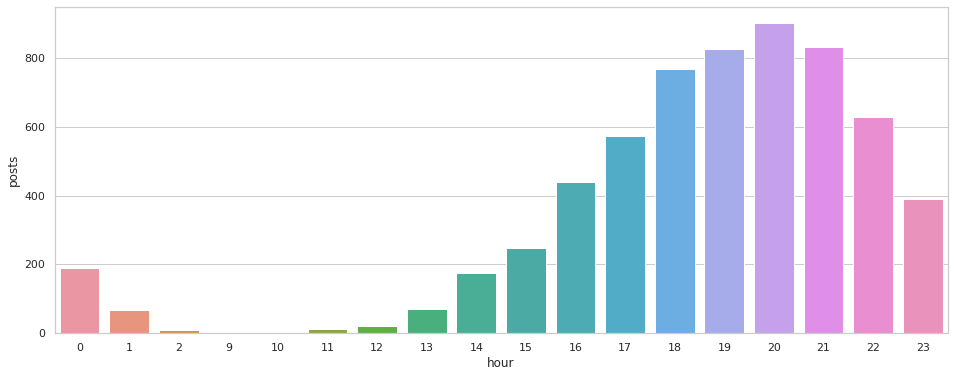

In [28]:
sns.barplot(data = new_posts_by_hour, x='hour', y='posts')

Что мы видим здесь:

* Публикация явно не круглосуточная - с 3 до 8 у нас радиомолчание
* Пик активности наблюдается в 20 часов 
* Это на час позже, чем пик активности пользователей (19 часов)

**Вывод:**

* Посты публикуются круглосуточно (Не верно)
* Примерно с 9 утра до 4 вечера активность пользователей одинаковая, с небольшой "просадкой" посередине **(Верно)**
* Пики активности пользователей и публикации постов не совпадают **(Верно)**
* Для активности пользователей характерен линейный рост в течение дня, сопровождающийся падением (Не верно)
* Больше всего постов публикуется в районе 8 вечера **(Верно)**
* Наименьшая активность пользователей наблюдается в 5 утра (Не верно)